In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import UpSampling2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

## Get the Training Data 

### The data is from the [faces_data_new](https://www.kaggle.com/gasgallo/faces-data-new) and [lag-dataset](https://www.kaggle.com/gasgallo/lag-dataset) from Kaggle. 

### The dataset consists of over 10,000 face pictures
### Here we resize the pictures to 64x64 and convet the images to a numpy array

In [4]:
def get_training_data(datafolder):
        print("Loading training data...")

        training_data = []
        #Get all the pictures from the data folder except the .DS_Store from MAC OS
        filenames = os.listdir(datafolder)
        for filename in tqdm(filenames):
            if filename == '.DS_Store':
                continue
            #Combines folder name and file name.
            else:
                path = os.path.join(datafolder,filename)
                #Opens an image as an Image object.
                image = Image.open(path)
                #Resizes to a desired size.
                image = image.resize((64,64),Image.ANTIALIAS)
                #Creates an array of pixel values from the image.
                pixel_array = np.asarray(image)

                training_data.append(pixel_array)

        #converted to a numpy array
        training_data = np.reshape(training_data,(-1,64,64,3))
        return training_data

## Define the Discriminator
### The discriminator is bulit in the following a Neural Network:
### In the network, we use the LeakyReLU as the activation layer inside the network since it is proved that it works well in GANs 
### Fron each layer, we also have a Dropout Layer and a BatchNormalization Layer
### In classfication layer we have a sigmoid activation which produces a probability that the picture is true
### Adam adaptive learning rate optimization algorithm and binary_crossentropy are also used here since it is recommended in the GANs 

In [5]:
def define_discriminator(in_shape=(64,64,3)):
	model = Sequential()

	model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=in_shape, padding="same"))
	model.add(LeakyReLU(alpha=0.2))
    
	# downsample
	model.add(Dropout(0.25))
	model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
	model.add(ZeroPadding2D(padding=((0,1),(0,1))))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))

	# downsample
	model.add(Dropout(0.25))
	model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))

	# downsample
	model.add(Dropout(0.25))
	model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))
    
	# downsample
	model.add(Dropout(0.25))
	model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(LeakyReLU(alpha=0.2))
    
	model.add(Dropout(0.25))
    
	# classifier
	model.add(Flatten())
	#model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

## Define the Generator
### The input is a vecotr of length latent_dim and the Generator outputs image of size 64*64*3
### relu activation is used and it also shared similar structure as the  discriminator

In [6]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, activation="relu",input_dim=latent_dim))

	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(UpSampling2D())
	model.add(Conv2D(256,kernel_size=3,padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(Activation("relu"))

	# upsample to 16x16
	model.add(UpSampling2D())
	model.add(Conv2D(256,kernel_size=3,padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(Activation("relu"))

	# upsample to 32x32
	model.add(UpSampling2D())
	model.add(Conv2D(128,kernel_size=3,padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(Activation("relu"))

    # upsample to 64x64
	model.add(UpSampling2D())
	model.add(Conv2D(128,kernel_size=3,padding="same"))
	model.add(BatchNormalization(momentum=0.8))
	model.add(Activation("relu"))

	# output layer
	model.add(Conv2D(3,kernel_size=3,padding="same"))
	model.add(Activation("tanh"))

	return model

## Combine the  generator and discriminator model

In [7]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


## Utility functions
### Some other functions that helps to load and select some real images; generate fake images and save the plots that the generartor generates during the training process and print the performances during traning. 

In [8]:
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
        
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

    
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()


## Training function:
### Step 1: for each epoch we have half of the pictures from the real pictures with label: 1(true) and half of them from the fake pictures with label: 1(true) generated from the generator 
### Step 2: we use them as the traning set form discriminator to tell if they can tell the fake pictures. 
### Step 3: The error of discriminator is then sent back to generator and help generator generates better pictures to trick the discriminator.

In [9]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=4000, n_batch=32):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

## Training Process (Takes a few days to finish the first 300 epoches...)

In [10]:
## The data is store in the data/images folder. But it is so large that we can not upload the folder to github, 
## please download the data from the links provided in the first section and put them into the correct position.  

data_set = get_training_data("..data/images")
data_set = data_set / 127.5 - 1.
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, data_set, latent_dim)

  0%|          | 24/11683 [00:00<00:49, 237.26it/s]

Loading training data...


100%|██████████| 11683/11683 [00:34<00:00, 336.86it/s]


### Load the models that we trained using different numbers of epoches and plot the fake images that the generator creates 

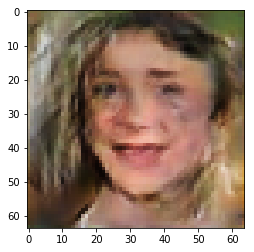

In [59]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('../output/generator_model_280.h5')
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()

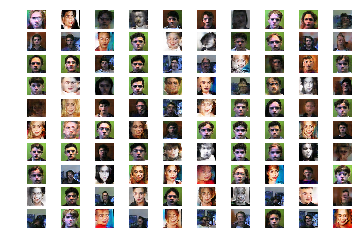

In [60]:
model = load_model('../output/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# Get fake images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)